In [1]:
import os
from copy import copy

import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps as cm

from photometry import Photometry
from scripts.tools import sort_files

star_name = "GRB 230818A"
_set = "first"
camera = 4
src_path = os.path.join(
    "..",
    "Dados GRB",
    star_name,
)


def read_objects_csv(src_path, camera):
    src_path = os.path.join(src_path, "..", "setup")
    csv_file = os.path.join(src_path, "objects coordinates.csv")
    df = pd.read_csv(csv_file)
    objects = df.loc[:, ["name", f"ra_cam{camera}", f"dec_cam{camera}"]]
    objects = objects.drop(
        objects[objects["name"] == "star shifts"].index
    ).reset_index()
    objects = objects.drop(["index"], axis=1)

    return objects


objects = read_objects_csv(src_path, camera)
file = os.path.join(src_path, f"{camera}_e_20230818_5_2_1_1.fits")
phot = Photometry(file, objects)
phot.reset_object_coords()

obj = phot.obj_list[0]
xcoord, ycoord = obj.xcoord, obj.ycoord
image = fits.getdata(file)
# image = image[ycoord - 300 : ycoord + 100, xcoord - 300 : xcoord + 100]
median = np.median(image)
std = np.median(np.abs(image - median))
cmap_reversed = cm.get_cmap("gray_r")
plt.imshow(
    image,
    vmax=median + 7 * std,
    vmin=median - 3 * std,
    origin="lower",
    cmap=cmap_reversed,
)


for idx, _object in enumerate(phot.obj_list):
    name, x, y = _object.name, _object.xcoord, _object.ycoord
    color = "b"
    if "circular" in name:
        color = "r"
    if "comparison" in name:
        color = "g"
    # x = x - xcoord + 300
    # y = y - ycoord + 300
    plt.plot(x, y, f"{color}o", alpha=0.5)
    plt.annotate(
        f"{name[-1]}",
        (x - 15, y),
        ha="right",
        va="center",
        fontsize=9,
        color="k",
    )


figure = os.path.join(src_path, "..", "plots", f"field_map.png")
plt.ylabel("Y axis (pixels)")
plt.xlabel("X axis (pixels)")
plt.savefig(figure, dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..\\Dados GRB\\GRB 230818A\\..\\setup\\objects coordinates.csv'

# Calculate the star radius

In [ ]:
import collections

from fits_files import FITS_files_manager

objects = read_objects_csv(src_path, camera)

star_radius = {"run_num": [], "star_radius": []}
ffiles = FITS_files_manager(src_path)
run_numbers = [obj.run_num for obj in ffiles.cam_files[f"cam{camera}"]]
run_numbers = [item for item, _ in collections.Counter(run_numbers).items()]
for run in run_numbers:
    tmp = []
    run_files = ffiles.get_images_by_run(run)
    for file in run_files[f"cam{camera}"]:
        file = os.path.join(src_path, file.name)
        phot = Photometry(file, objects)
        phot.reset_object_coords()
        tmp.append(phot.calculate_star_radius(coeff_radius_fwhm=2))
    median = np.median(tmp)
    star_radius["star_radius"].append(median)
    star_radius["run_num"].append(run)


dest_files_path = os.path.join(src_path, "..", "polarimetry")
df = pd.DataFrame.from_dict(star_radius)
csv_file = os.path.join(dest_files_path, f"star_radius_cam{camera}.csv")
df.to_csv(csv_file, index=False)

# Create photometry.csv

In [ ]:
objects = read_objects_csv(src_path, camera)
# objects = objects.loc[objects["name"] == "candidate1"]


objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "star_radius": [],
        "star_photons": [],
        "star_error": [],
    }

csv_file = os.path.join(dest_files_path, f"star_radius_cam{camera}.csv")
df = pd.read_csv(csv_file)
row = df.loc[df["run_num"] == 2]
star_radius = row["star_radius"].iloc[0]
image_list = sort_files(src_path, f"{camera}_e")


for file in image_list:
    file_path = os.path.join(src_path, file)
    phot = Photometry(file_path, objects)
    phot.reset_object_coords()
    phot.star_radius = star_radius
    phot.calc_sky_photons()
    phot.calc_star_photons()

    for idx, _object in enumerate(phot.obj_list):
        objects_photometry[_object.name]["mjd"].append(_object.mjd)
        objects_photometry[_object.name]["xcoord"].append(_object.xcoord)
        objects_photometry[_object.name]["ycoord"].append(_object.ycoord)
        objects_photometry[_object.name]["star_radius"].append(phot.star_radius)
        objects_photometry[_object.name]["star_photons"].append(_object.star_photons)
        objects_photometry[_object.name]["star_error"].append(_object.star_err)
        # objects[f"ra_cam{camera}"][idx] = _object.ra
        # objects[f"dec_cam{camera}"][idx] = _object.dec

for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(dest_files_path, f"{obj_name}_cam{camera}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

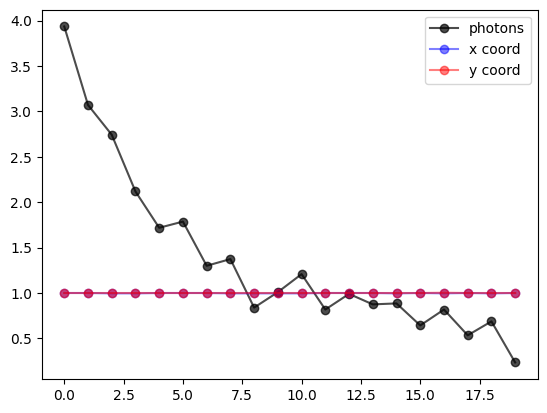

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

src_path = os.path.join("..", "Dados GRB")



target = "candidate1"


dest_files_path = os.path.join(src_path, "photometry")  # TODO


file = os.path.join(dest_files_path, f"{target}_cam{3}.csv")


df = pd.read_csv(file)


lim_dix = 16 * 20


df = df[:lim_dix]


x, y, radius, photons, mjd = (
    df["xcoord"],
    df["ycoord"],
    df["star_radius"],
    df["star_photons"],
    df["mjd"],
)


x /= np.median(x)


y /= np.median(y)


photons /= np.median(photons)


mjd = (mjd - mjd[0]) * 24 * 60


plt.plot(photons, "k-o", alpha=0.7, label="photons")


plt.plot(x, "b-o", alpha=0.5, label="x coord")


plt.plot(y, "r-o", alpha=0.5, label="y coord")


plt.legend()


plt.show()

# Looking at the comparison star

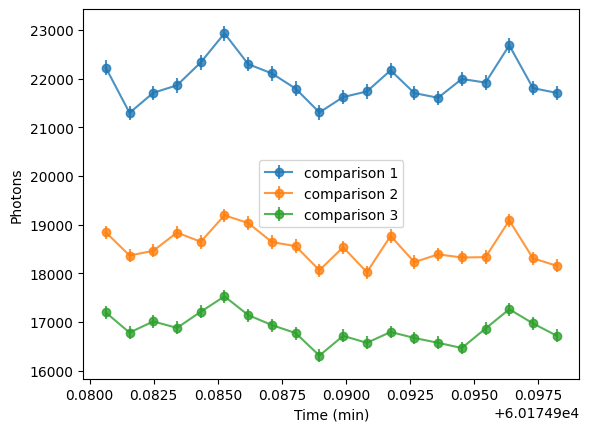

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


def combine_cameras_flux(idx):


    df_cam3 = pd.read_csv(
        os.path.join(src_path, "photometry", f"comparison{idx}_cam3.csv")
    )


    df_cam4 = pd.read_csv(
        os.path.join(src_path, "photometry", f"comparison{idx}_cam4.csv")
    )


    df_cam3 = df_cam3[:lim_dix]


    df_cam4 = df_cam4[:lim_dix]


    mjd = df_cam3["mjd"]


    comp = df_cam3["star_photons"] + df_cam4["star_photons"]


    comp_err = np.sqrt(df_cam3["star_error"] ** 2 + df_cam4["star_error"] ** 2)


    return mjd, comp, comp_err



for idx in range(3):


    mjd, comp, comp_err = combine_cameras_flux(idx + 1)


    plt.errorbar(mjd, comp, comp_err, fmt="o-", alpha=0.8, label=f"comparison {idx+1}")


plt.legend()


plt.xlabel("Time (min)")


plt.ylabel("Photons")


plt.show()

# Creating the final comparison

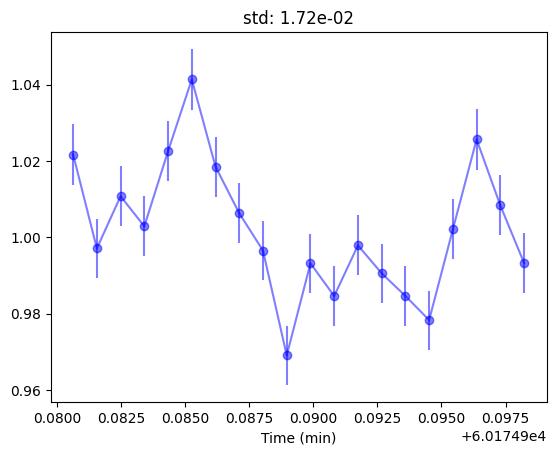

In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def read_comp_csv_files(_list):
    comp, comp_err = [], []
    for idx in _list:
        mjd, tmp, tmp_err = combine_cameras_flux(idx)
        comp.append(tmp)
        comp_err.append(tmp_err)

    comp = np.sum(comp, axis=0)
    comp_err = np.sqrt(np.sum(np.square(comp_err), axis=0))

    return mjd, comp, comp_err


comp_idx = 3
comparisons_list = [comp_idx]
mjd, comp, comp_err = read_comp_csv_files(comparisons_list)
median = np.median(comp)
comp /= median
comp_err /= median
std = np.std(comp)
plt.errorbar(mjd, comp, comp_err, fmt="bo-", alpha=0.5)
plt.title(f"std: {std:.2e}")
plt.xlabel("Time (min)")
plt.show()

csv_file = os.path.join(src_path, "setup", "objects coordinates copy.csv")
df = pd.read_csv(csv_file)
row = df.loc[df["name"] == f"comparison{comp_idx}"]
comp_magR = row["Rmag"].iloc[0]

# Plot light curve

alpha_r = 2.48 +- 0.13
alpha_f = 1.45 +- 0.57
t_flat = 0.05 +- 0.10 s
chi^2 = 0.031


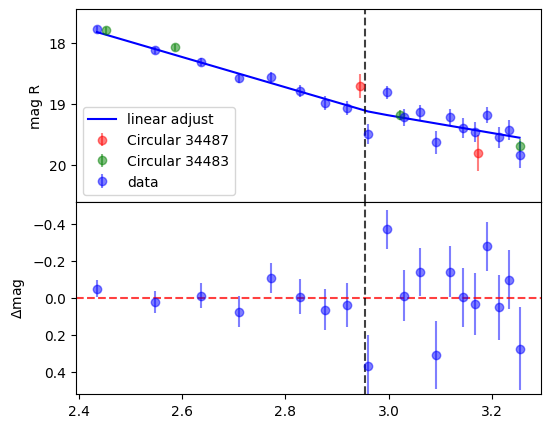

In [21]:
import os
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from scipy.constants import c, h
from scipy.interpolate import UnivariateSpline
from scipy.stats import chisquare


def calc_obj_magnitude(star_photons, star_err, comp_photons, comp_err, comp_magR):
    star_photons, comp_photons = np.asarray(star_photons), np.asarray(comp_photons)

    tmp = star_photons / comp_photons
    tmp_err = np.abs(tmp) * np.sqrt(
        (star_err / star_photons) ** 2 + (comp_err / comp_photons) ** 2
    )
    star_mag = -2.5 * np.log10(tmp) + comp_magR
    star_mag_err = 2.5 * tmp_err / (tmp * np.log(10))
    return star_mag, star_mag_err


def calc_linear_adjust(x, y):
    p, cov = np.polyfit(x, y, 1, cov=True)
    a, b = p
    return a * x + b, a, b, cov


def plot_light_curve(ax, mjd, cand, cand_err, adjust, n_std=1):
    mean = np.mean(cand)
    std = np.std(cand)

    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.5, label="data", ls="none"
    )
    ax.plot(mjd, adjust, "b-", label="linear adjust")
    ax.set_ylim(mean - n_std * std, mean + 1 * n_std * std)
    ax.set_ylabel(r"mag R")
    ax.invert_yaxis()
    ax.axvline(np.log10(14.99 * 60), color="k", ls="--", alpha=0.75)
    ax.legend(loc="lower left")


def comb_linear_adjust(mjd, adjus_param1, adjus_param2):
    a, b = adjus_param1
    if mjd > np.log10(16 * 60):
        a, b = adjus_param2

    return a * mjd + b


def plot_residuals(ax, mjd, cand, cand_err, adjust, ycoord, n_std=3):
    residuals = cand - adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.5,
        label="data",
        ls="none",
    )
    ax.set_ylabel(r"$\Delta$mag")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - n_std * std, mean + n_std * std)
    # ax.set_xlabel("Log(t - T0)")
    ax.axvline(np.log10(14.99 * 60), color="k", ls="--", alpha=0.75)
    ax.invert_yaxis()


def plot_circular_data(mjd_start: float, ax):
    circulars = ["34487", "34483"]
    for idx, circular in enumerate(circulars):
        csv_path = os.path.join(src_path, "Circulars", circular + ".csv")
        df = pd.read_csv(csv_path)
        utc = df["UT start"].values
        n = 4
        mjd = [Time(value, format="isot").to_value("mjd") for value in utc] - mjd_start
        mjd *= 24 * 60 * 60
        mjd = np.log10(mjd)
        mag = df["Rmag"]
        mag_err = df["err"]

        ax.errorbar(
            mjd[:n],
            mag[:n],
            mag_err[:n],
            marker="o",
            color=["r", "g"][idx],
            label="Circular " + circular,
            alpha=0.5,
            ls="none",
        )


def convert_mag_to_photons(mag, mag_err, exp_time):
    lamb_eff = 0.641e-6
    tel_area = (1 - 0.225) ** 2 * pi
    f_nu = 3.064e-23
    p_energy = h * c / lamb_eff
    f_R = f_nu * lamb_eff * tel_area * exp_time / p_energy

    photons = 10 ** (mag / -2.5) * f_R
    photons_err = mag_err
    return photons, photons_err


def read_star_csv_files(candidate):
    df_cam3 = pd.read_csv(
        os.path.join(src_path, "photometry", f"candidate{candidate}_cam3.csv")
    )
    df_cam4 = pd.read_csv(
        os.path.join(src_path, "photometry", f"candidate{candidate}_cam4.csv")
    )
    df_cam3 = df_cam4[:lim_dix]
    df_cam4 = df_cam4[:lim_dix]

    cand = df_cam3["star_photons"] + df_cam4["star_photons"]
    cand_err = np.sqrt(df_cam3["star_error"] ** 2 + df_cam4["star_error"] ** 2)

    mjd = df_cam3["mjd"]

    return mjd, cand, cand_err


fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex="col", sharey="row")
mjd, star, star_err = read_star_csv_files(candidate=1)
mjd, comp, comp_err = read_comp_csv_files(comparisons_list)
time_start = "2023-08-18T23:27:34"
t = Time(time_start, format="isot", scale="utc")
mjd_start = t.to_value("mjd")
mjd = (mjd - mjd_start) * 24 * 60 * 60
norm_star, norm_err = calc_obj_magnitude(star, star_err, comp, comp_err, comp_magR)

mjd = np.log10(mjd)

idx = 10
norm_star_interv, norm_err_interv = norm_star[:idx], norm_err[:idx]
mjd_interv = mjd[:idx]
_, *adjust_param1, cov1 = calc_linear_adjust(mjd_interv, norm_star_interv)
idx -= 2
norm_star_interv, norm_err_interv = norm_star[idx:], norm_err[idx:]
mjd_interv = mjd[idx:]
_, *adjust_param2, cov2 = calc_linear_adjust(mjd_interv, norm_star_interv)
adjust = [comb_linear_adjust(time, adjust_param1, adjust_param2) for time in mjd]

plot_circular_data(mjd_start, axs[0])
plot_light_curve(
    axs[0],
    mjd,
    norm_star,
    norm_err,
    adjust,
    3,
)
plot_residuals(axs[1], mjd, norm_star, norm_err, adjust, 0.95, 3)

plt.subplots_adjust(hspace=0)
plt.savefig(os.path.join(src_path, "plots", "light_curve splitted.png"), dpi=300)


a1, b1 = adjust_param1
a2, b2 = adjust_param2
a1_err, b1_err = np.diag(cov1)
a2_err, b2_err = np.diag(cov2)
t_flat = np.abs((b1 - b2) / (a1 - a2)) / 60
t_err_1 = np.sqrt(b1_err**2 + b2_err**2)
t_err_2 = np.sqrt(a1_err**2 + a2_err**2)
t_err = t_flat * np.sqrt((t_err_1 / (b1 - b2)) ** 2 + (t_err_2 / (a1 - a2)) ** 2)
chi = np.abs(
    chisquare(
        norm_star, np.sum(norm_star) / np.sum(adjust) * np.asarray(adjust)
    ).statistic
)

print(f"alpha_r = {a1:.2f} +- {a1_err:.2f}")
print(f"alpha_f = {a2:.2f} +- {a2_err:.2f}")
print(f"t_flat = {t_flat:.2f} +- {t_err:.2f} s")
print(f"chi^2 = {chi:.3f}")


plt.show()

# Calculating the polarization

NameError: name 'read_star_csv_files' is not defined

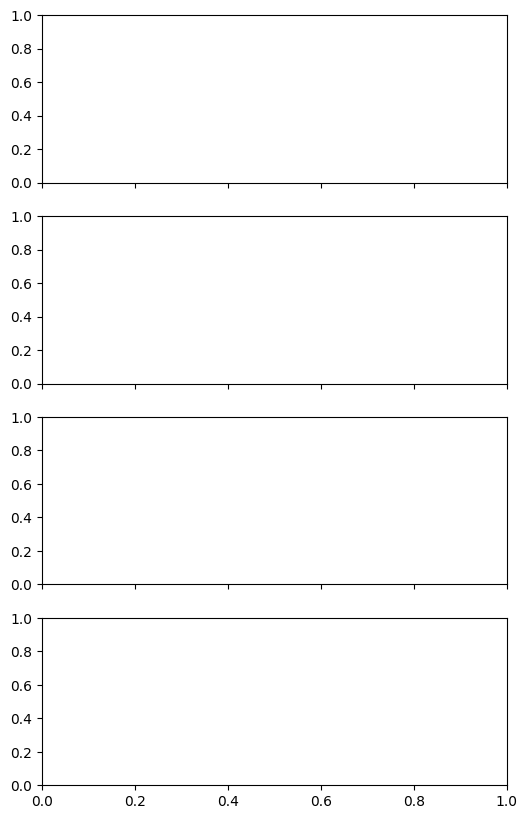

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scripts.tools import (
    calculate_polarization_and_phase,
    get_instrumental_polarization,
    novel_pol_error,
)

star_name = "GRB 230818A"
base_path = os.path.join(
    "..",
    "Dados GRB",
    star_name,
)
filter = "R"
fig, axs = plt.subplots(4, 1, figsize=(6, 10), sharex="col")
mjd, star, star_err = read_star_csv_files(candidate=1)
mjd = (mjd - mjd_start) * 24 * 60 * 60
mjd = np.log10(mjd)
plot_circular_data(mjd_start, axs[0])
plot_light_curve(
    axs[0],
    mjd,
    norm_star,
    norm_err,
    adjust,
    3,
)
plot_residuals(axs[1], mjd, norm_star, norm_err, adjust, 0.95, 3)

markers = [
    "o",
    "s",
    "p",
    "*",
    "+",
    "X",
    "D",
    "v",
    "<",
    ">",
    "^",
    "8",
]

for idx, cand_num in enumerate([1, 3, 4, 7, 8]):
    file = f"cand{cand_num}.csv"
    marker = f"{markers[idx]}b"
    lab = file.split(".")[0]

    if "cand1" in file:
        marker = f"or"
        lab = "target"

    csv_file_name = os.path.join(base_path, file)
    df = pd.read_csv(csv_file_name)
    q, u = df["q_avg"], df["u_avg"]
    q_err, u_err = df["q_err"], df["u_err"]
    x, y = df["x"], df["y"]
    mjd = df["mjd"]
    mjd = (mjd - mjd_start) * 24 * 60 * 60
    mjd = np.log(mjd)

    q_inst = get_instrumental_polarization(x, y, filter, "q")
    u_inst = get_instrumental_polarization(x, y, filter, "u")
    q_inst_err = np.std(q_inst)
    u_inst_err = np.std(u_inst)
    q -= q_inst
    u -= u_inst
    q_err = np.sqrt(q_err**2 + q_inst_err**2)
    u_err = np.sqrt(u_err**2 + u_inst_err**2)
    pol, pol_err, phase, phase_err = calculate_polarization_and_phase(
        q, q_err, u, u_err
    )
    pol, pol_err, p_mas, p_mas_err, p_min, p_max = novel_pol_error(q, q_err, u, u_err)

    ax = axs[2]
    ax.errorbar(
        mjd,
        p_mas,
        p_mas_err,
        fmt=marker,
        alpha=0.5,
        label=lab,
    )
    ax.set_ylabel(f"Polarization (%)")
    ax.set_ylim(0, 30)
    ax.legend()
    ax = axs[3]
    ax.errorbar(
        mjd,
        phase,
        phase_err,
        fmt=marker,
        alpha=0.5,
        label=lab,
    )
    ax.set_ylabel("Phase (deg)")
    ax.set_xlabel("Time (s)")
    ax.legend()
    ax.set_ylim(-150, 150)
    ax.set_xlabel("Log(t - T0)")
fig_file = os.path.join(src_path, "..", "plots", "moptop_pol.png")
plt.subplots_adjust(hspace=0.1, bottom=0.05, top=0.99)
plt.savefig(fig_file, dpi=300)

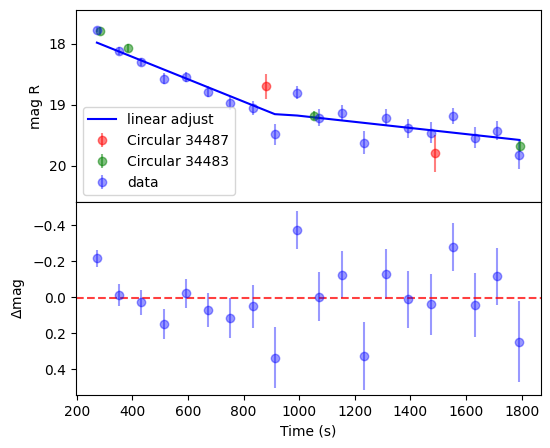

In [16]:
import os
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from scipy.constants import c, h
from scipy.interpolate import UnivariateSpline
from scipy.stats import chisquare

fig, axs = plt.subplots(4, 1, figsize=(6, 5), sharex="col", sharey="row")
mjd, star, star_err = read_star_csv_files(candidate=1)
mjd = (mjd - mjd_start) * 24 * 60 * 60
plot_circular_data(mjd_start, axs[0])
plot_light_curve(
    axs[0],
    mjd,
    norm_star,
    norm_err,
    adjust,
    3,
)
plot_residuals(axs[1], mjd, norm_star, norm_err, adjust, 0.95, 3)

plt.subplots_adjust(hspace=0)
plt.savefig(os.path.join(src_path, "..", "plots", "light_curve splitted.png"), dpi=300)
plt.show()

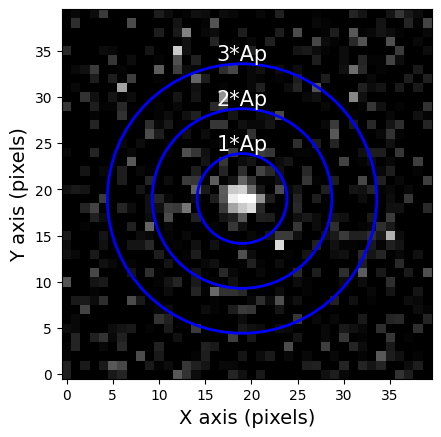

In [54]:
import os
from copy import copy

import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from photometry import Photometry
from scripts.tools import sort_files

star_name = "GRB 230818A"
_set = "first"
camera = 3
src_path = os.path.join(
    'tests', 'shifted_images'
)


def read_objects_csv(src_path, camera):
    src_path = os.path.join(src_path, "..", "setup")
    csv_file = os.path.join(src_path, "objects coordinates copy.csv")
    df = pd.read_csv(csv_file)
    objects = df.loc[:, ["name", f"ra_cam{camera}", f"dec_cam{camera}"]]
    objects = objects.drop(
        objects[objects["name"] == "star shifts"].index
    ).reset_index()
    objects = objects.drop(["index"], axis=1)

    return objects


# objects = read_objects_csv(src_path, camera)
# objects = objects.loc[objects["name"] == "candidate1"]
file = os.path.join(src_path, f"{camera}_e_20230818_5_1_1_1.fits")
# phot = Photometry(file, objects)
# phot.reset_object_coords()

# obj = phot.obj_list[0]
size = 20
xcoord, ycoord = 292, 381
xcoord, ycoord = 262, 322
image = fits.getdata(file)
image = image[ycoord - size : ycoord + size, xcoord - size : xcoord + size]
median = np.median(image)
std = np.median(np.abs(image - median))

vmin, vmax = np.percentile(image, [60,99.9])
plt.figure()
ax = plt.gca()
plt.imshow(
    image, origin="lower", cmap="gray", vmin = vmin, vmax = vmax
)
aperture = 4.86
circle = plt.Circle((size - 1, size - 1), aperture, color="b", fill=False, linewidth=2)
ax.add_artist(circle)
circle = plt.Circle(
    (size - 1, size - 1), 3 * aperture, color="b", fill=False, linewidth=2
)
ax.add_artist(circle)
circle = plt.Circle(
    (size - 1, size - 1), 2 * aperture, color="b", fill=False, linewidth=2
)
ax.add_artist(circle)

plt.annotate(
    "1*Ap", (size - 1, size + aperture), size=15, ha="center", va="center", color="w"
)
plt.annotate(
    "2*Ap",
    (size - 1, size + 2 * aperture),
    size=15,
    ha="center",
    va="center",
    color="w",
)
plt.annotate(
    "3*Ap",
    (size - 1, size + 3 * aperture),
    size=15,
    ha="center",
    va="center",
    color="w",
)
plt.ylabel("Y axis (pixels)", fontsize=14)
plt.xlabel("X axis (pixels)", fontsize=14)
figure = os.path.join(src_path, "..", "figures", f"targert.png")
plt.savefig(figure, dpi=300)
plt.show()